In [1]:
import sys

import numpy as np
import pandas as pd 
import networkx as nx
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sns.set_theme()
sns.set_style("whitegrid", {"grid.color": "0.9"})

linewidth = 0.5
params = {'font.family':'serif', 
          'font.serif':'Computer Modern',
          'text.usetex':True,
          'text.latex.preamble': r'\usepackage{amsfonts}',
          'figure.constrained_layout.use':True,
          'figure.figsize':(5, 4.624),
          'savefig.pad_inches':0.015,
          'axes.linewidth': linewidth,
          'grid.linewidth': linewidth,
          'xtick.major.pad': -2,
          'ytick.major.pad': -2}

plt.rcParams.update(params)

In [3]:
# Fix colors
SIZE_TWO_COLOR = 'darkgrey'
SIZE_THREE_COLOR = '#FFBC79'
SIZE_FOUR_COLOR = '#79BCFF'
hye_facecolor = {SIZE_TWO_COLOR: 'black', SIZE_THREE_COLOR: "#C85200", SIZE_FOUR_COLOR: "#006BA4"}

## Project "Higher-order data"

In [4]:
sys.path.append("../../../_Contributing/hgx/")
import hypergraphx
from hypergraphx import Hypergraph
from hypergraphx.readwrite.loaders import load_high_school
from hypergraphx.filters import get_svh
from hypergraphx.viz.draw_hypergraph import draw_hypergraph
from hypergraphx.representations.projections import clique_projection

##### Input data

In [5]:
H = load_high_school("../../../_Contributing/hgx/test_data/hs/hs.json", filter_by_class=['PC*'])
print(H)

Hypergraph with 39 nodes and 754 edges.
Distribution of hyperedge sizes: {2: 519, 3: 217, 4: 18}


In [6]:
# Get validated hyperedges
hs_svh = get_svh(H, mp=True)

# Filter hypergraph
e4 = hs_svh[4]
e4 = e4[e4['fdr']]
lim = e4['pvalue']
lim = list(lim)
lim = list(sorted(lim))
print(lim)
lim = lim[-1]

edges = []
lim = float(lim)

for size in hs_svh:
    for i in range(len(hs_svh[size])):
        a = float(hs_svh[size]['pvalue'][i])
        b = bool(hs_svh[size]['fdr'][i])
        if a <= lim and b:
            edges.append(hs_svh[size]['edge'][i])

print(len(edges))

H2 = Hypergraph(edges)
lcc = H2.largest_component()
H2 = H2.subhypergraph(lcc)

[3.0771767141041745e-07]
61


##### Plot

In [7]:
hyperedge_color_by_order = {2: SIZE_THREE_COLOR, 3: SIZE_FOUR_COLOR}
hyeperedge_facecolor_by_order = {2: hye_facecolor[SIZE_THREE_COLOR], 3: hye_facecolor[SIZE_FOUR_COLOR]}

In [8]:
pos = nx.spring_layout(clique_projection(H2, keep_isolated=True),
                       iterations=120, seed=17, scale=1, k=0.75)
pos[214] = [0.17580071, 0.07780574]
pos[116] = [-0.02649419,  0.14016711]
pos[923] = [-0.50259044, -0.20990672]

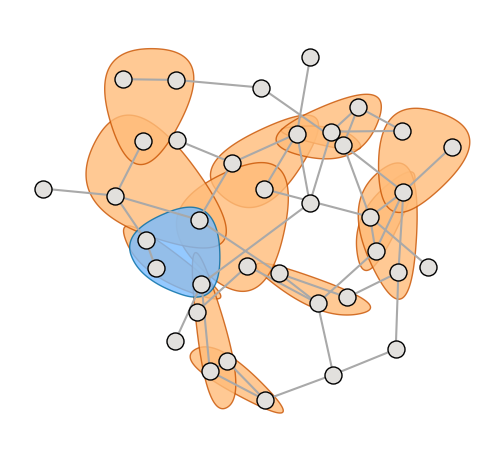

In [9]:
plt.subplot(1,1,1)
ax=plt.gca()

draw_hypergraph(
    H2, ax=ax, pos=pos,
    edge_width=1.5, edge_color=SIZE_TWO_COLOR, hyperedge_color_by_order=hyperedge_color_by_order, 
    hyperedge_facecolor_by_order=hyeperedge_facecolor_by_order, hyperedge_alpha=0.8,
    node_size=150, node_color='#E2E0DD', node_facecolor='black', node_shape='o', with_node_labels=False
)
sns.despine()
plt.savefig("img/project_2.jpg", dpi=600)

## Project "Attributed multilayer networks"

In [10]:
# Generate SBM
sizes = [15, 10, 10]
probs = [[0.25, 0.01, 0.07], [0.01, 0.35, 0.15], [0.07, 0.15, 0.20]]
G = nx.stochastic_block_model(sizes, probs, seed=1)
# Transform graph to a multigraph
G2 = nx.MultiGraph()
G2.add_nodes_from(G.nodes())
keys = G2.add_edges_from(G.edges())

In [11]:
pos = nx.spring_layout(G, iterations=150, seed=2, scale=1.5, k=0.8)

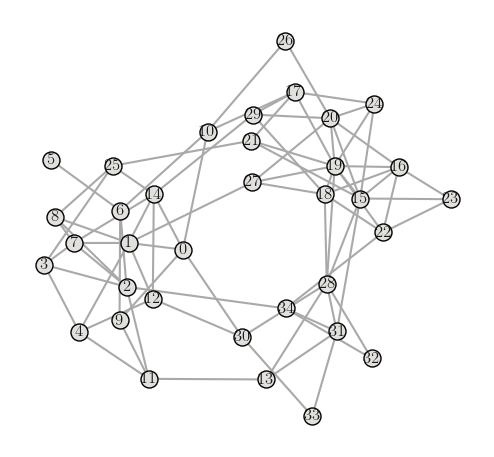

In [12]:
plt.subplot(1,1,1)
ax=plt.gca()
nx.draw_networkx(G2, ax=ax, pos=pos, width=1.5, edge_color=SIZE_TWO_COLOR, node_size=150, 
                 node_color='#E2E0DD', edgecolors='black', with_labels=True)
sns.despine()
plt.axis('off')
plt.show()

In [13]:
# Add parallel edges
G2.add_edges_from([(11, 13), (10, 26), (1, 27), (2, 34)])
for e in G2.edges(keys=True):
    G2.edges[e]['color'] = np.random.choice(["#C8D6E4", "#E4D6C8"])

In [14]:
# Assign color to nodes representing metadata
cmap = matplotlib.colormaps.get_cmap('tab20')
colors = ["#B3DFB0", "#FFBC79", "#B0DFDB", "#DCB0DF"]
colors_nodes = []
for i, _ in enumerate(G2.nodes()):
    if i < 15:
        colors_nodes.append(colors[np.random.choice([2, 3])])
    elif i < 25:
        colors_nodes.append(colors[np.random.choice([0, 1])])
    else:
        colors_nodes.append(colors[np.random.choice(4)])

In [17]:
# Make sure parallel edges are of different colors
G2.edges[(10, 26, 0)]['color'] = "#C8D6E4"

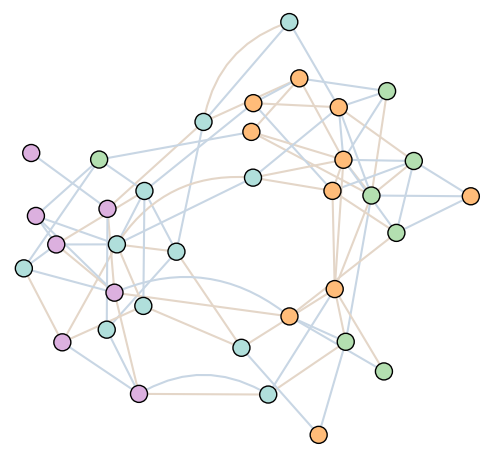

In [18]:
plt.subplot(1,1,1)
ax=plt.gca()
nx.draw_networkx_nodes(G2, ax=ax, pos=pos, node_color = colors_nodes, node_size = 150, 
                       edgecolors='black', alpha=1)
for e in G2.edges:
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                zorder=-1,
                arrowprops=dict(arrowstyle="-", color=G2.edges[e]['color'], lw=1.5,
                                shrinkA=6, shrinkB=6,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                ),
                                ),
                )

plt.axis('off')
plt.savefig("img/project_1.jpg", dpi=600)
plt.show()

In [37]:
for e in G2.edges(keys=True):
    G2.edges[e]['color'] = np.random.choice(["#FFD5AB", "#ABD5FF"])

In [33]:
# Assign color to nodes representing metadata
cmap = matplotlib.colormaps.get_cmap('Greys')
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
colors_nodes = []
for i, _ in enumerate(G2.nodes()):
    if i < 15:
        colors_nodes.append(cmap(norm(np.random.choice([1, 3]))))
    elif i < 25:
        colors_nodes.append(cmap(norm(np.random.choice([5, 7]))))
    else:
        colors_nodes.append(cmap(norm(np.random.choice([3, 4, 5]))))

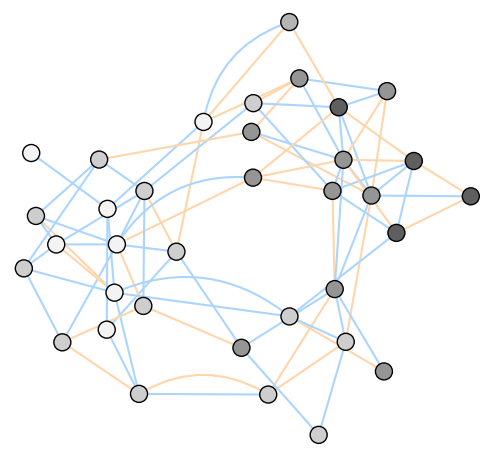

In [38]:
plt.subplot(1,1,1)
ax=plt.gca()
nx.draw_networkx_nodes(G2, ax=ax, pos=pos, node_color = colors_nodes, node_size = 150, 
                       edgecolors='black', alpha=1)
for e in G2.edges:
    ax.annotate("",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                zorder=-1,
                arrowprops=dict(arrowstyle="-", color=G2.edges[e]['color'], lw=1.5,
                                shrinkA=6, shrinkB=6,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                ),
                                ),
                )

plt.axis('off')
plt.savefig("img/project_1a.jpg", dpi=600)
plt.show()

## Project "Reciprocity"

In [57]:
# Generate SBM
sizes = [7, 8]
probs = [[0.25, 0.1], [0.08, 0.25]]
G = nx.stochastic_block_model(sizes, probs, seed=0, directed=True)

In [73]:
colors_edges = []
for i, j in G.edges():
    if (j, i) in G.edges():
        colors_edges.append("#DF987B")
    else:
        colors_edges.append(SIZE_TWO_COLOR)

In [74]:
pos = nx.spring_layout(G, iterations=100, seed=39, scale=1.5, k=0.8)

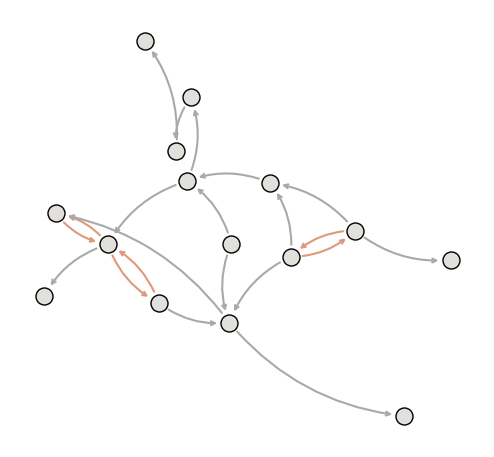

In [75]:
plt.subplot(1,1,1)
ax=plt.gca()
nx.draw_networkx_nodes(G, ax=ax, pos=pos, node_color = '#E2E0DD', node_size = 150, 
                       edgecolors='black', alpha=1)
nx.draw_networkx_edges(G, ax=ax, pos=pos, width=1.5, edge_color=colors_edges,
                      connectionstyle="arc3,rad=0.2", arrowsize=7, arrowstyle="->")
sns.despine()
plt.axis('off')
plt.savefig("img/project_3.jpg", dpi=600)
plt.show()